In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-11-25 20:03:28.170503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 20:03:28.266455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 20:03:28.266469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-25 20:03:28.282668: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 20:03:28.711595: W tensorflow/stream_executor/platform/de

In [3]:
import pathlib
data_dir = pathlib.Path('data/train/')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


280


# LOAD DATASET

In [4]:
batch_size = 32
# Las imagenes presentes en el dataset se encuentran en una resolucion de 64x64
img_height = 64
img_width = 64

Importamos el dataset con la utilidad de [image dataset from directory para hacerlo de manera mas eficiente](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory). El usar esta utilidad nos permite ademas de importar las imagenes de manera mas sencilla, el definir los subsets de entrenamiento y validacion.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 280 files belonging to 6 classes.
Using 224 files for training.


2022-11-25 20:03:29.574956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 20:03:29.575128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 20:03:29.575159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-25 20:03:29.575186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-25 20:03:29.575212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 280 files belonging to 6 classes.
Using 56 files for validation.


Comprobamos que haya usado el nombre de los directorios como etiquetas

In [7]:
class_names = train_ds.class_names
print(class_names)

['Alegria', 'Asco', 'Enojo', 'Miedo', 'Sorpresa', 'Tristeza']


Visualizamos las primeras 9 imagenes presentes en el dataset de entrenamiento para comprobar que se hayan cargado correctamente

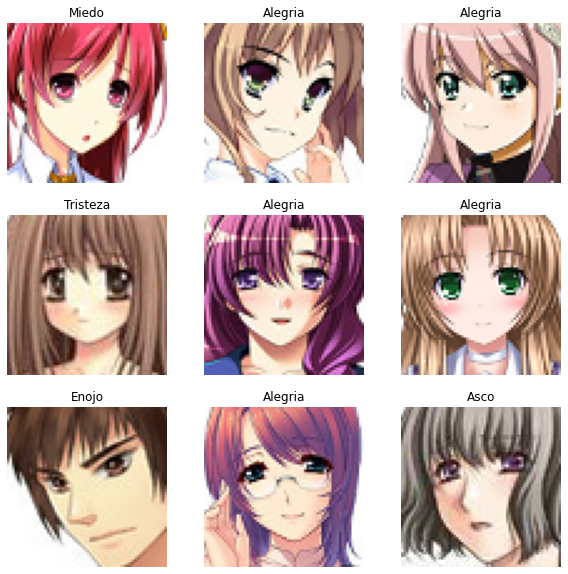

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configuramos el dataset para que tenga un rendimiento optimo

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ETL

## Estandarizacion de los datos

Dentro del modelo estandarizamos las imagenes mediante una capa de rescaling, reduciendo el rango de valores de las imagenes, pasando de un rango de 0 a 255 (RGB) a un rango de 0 a 1, esto debido a que es mas ideal para la red neuronal un rango de valores mas pequeños ya que permite que el modelo aprenda con mayor facilidad.

## Data augmentation

Generamos data augmentation con el fin de tener mas datos para entranar al modelo.

In [10]:
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4),
    ]
)

Comprobamos que el data augmentatio este funcionando correctamente

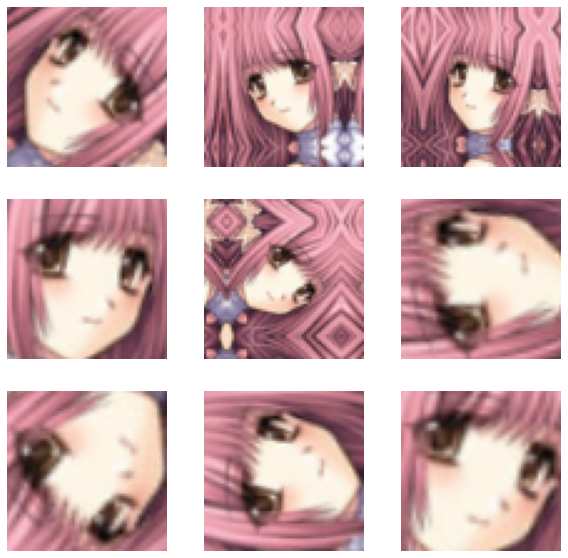

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Modelado

## Capas

A parte de las capas previamente mencionadas, se utilizaron las siguientes capas.

- ### Convolutiva (Conv2D):
    El objetivo del uso de este tipo de capa es extraer las caracteristicas de las imagenes mediante la implementacion de un kernel convolutivo.
    
    Las capas presente en el modelo de este tipo se encuentran configuradas para que la salida resultante tenga la misma resolucion que la entrada mediante padding. Las capas resentan una activacion de tipo relu.

- ### Pooling (MaxPooling2D):
    Nos permite reducir la dimensionalidad de la entrada, reduciendo el nuemro de parametros, y por lo tanto reduciendo el coste de calculo en el modelo.

- ### Flatten
    Durante las capas anteriores hemos venido trabajando con matrices 2D, sin embargo para poder realizar la clasificacion con las siguientes capas es necesario tener el resultado de las capas previas en un vector lineal, el cual es el motivo de esta capa, ya que se encarga de transformar las entrada 2D en un vector lineal.

- ### Dense
    Estas capas son las encargadas de realizar la clasificacion.

In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenamiento

In [14]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/15
7/7 [==============================] - 3s 71ms/step - loss: 1.5988 - accuracy: 0.4554 - val_loss: 1.3336 - val_accuracy: 0.6786
Epoch 2/15
7/7 [==============================] - 0s 37ms/step - loss: 1.4334 - accuracy: 0.5402 - val_loss: 1.1233 - val_accuracy: 0.6786
Epoch 3/15
7/7 [==============================] - 0s 35ms/step - loss: 1.3962 - accuracy: 0.5402 - val_loss: 1.1666 - val_accuracy: 0.6786
Epoch 4/15
7/7 [==============================] - 0s 34ms/step - loss: 1.3884 - accuracy: 0.5402 - val_loss: 1.1446 - val_accuracy: 0.6786
Epoch 5/15
7/7 [==============================] - 0s 36ms/step - loss: 1.3796 - accuracy: 0.5402 - val_loss: 1.1401 - val_accuracy: 0.6786
Epoch 6/15
7/7 [==============================] - 0s 35ms/step - loss: 1.3816 - accuracy: 0.5402 - val_loss: 1.1524 - val_accuracy: 0.6786
Epoch 7/15
7/7 [==============================] - 0s 37ms/step - loss: 1.3759 - accuracy: 0.5402 - val_loss: 1.1497 - val_accuracy: 0.6786
Epoch 8/15
7/7 [===========

# Analisis del modelo

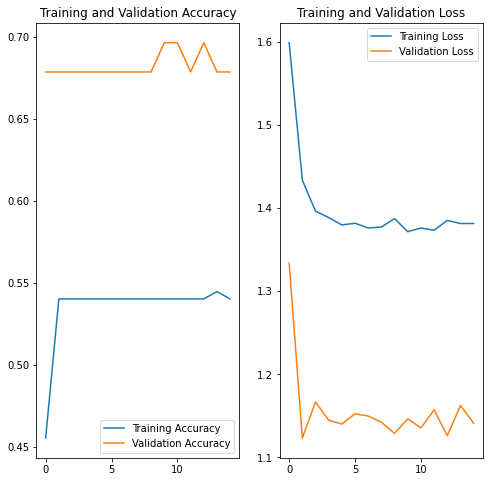

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observaciones

- Datos de validacion:
    Se puede observar el como la precision del modelo se mantiene al mismo nivel a traves de las mayorias de las epocas, a la vez que su bias incrementa de forma erratica.

- Datos de entrenamiento
    Se puede observar el como las precision no logra incrementar considerablemente y rapidadmente se estanca. Si bien su bias se va reduciendo a lo largo de las epocas, precesnta un bias muy alto.

Por las observaciones podemos concluir que el modelo esta haciendo undefitting, y que esta siendo incapaz de adaptarse a los datos.

# Mejoras al modelo

In [186]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.1),
  layers.Conv2D(128, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.1),
  layers.Conv2D(256, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.8),
  layers.Flatten(),
   layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [187]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/200


7/7 [==============================] - 4s 232ms/step - loss: 1.7862 - accuracy: 0.4821 - val_loss: 1.6898 - val_accuracy: 0.6786
Epoch 2/200
7/7 [==============================] - 1s 184ms/step - loss: 1.6211 - accuracy: 0.4688 - val_loss: 1.1788 - val_accuracy: 0.6786
Epoch 3/200
7/7 [==============================] - 1s 199ms/step - loss: 1.4973 - accuracy: 0.5402 - val_loss: 1.3714 - val_accuracy: 0.6786
Epoch 4/200
7/7 [==============================] - 1s 194ms/step - loss: 1.4148 - accuracy: 0.5402 - val_loss: 1.1378 - val_accuracy: 0.6786
Epoch 5/200
7/7 [==============================] - 1s 212ms/step - loss: 1.4422 - accuracy: 0.5402 - val_loss: 1.2311 - val_accuracy: 0.6786
Epoch 6/200
7/7 [==============================] - 1s 210ms/step - loss: 1.4088 - accuracy: 0.5402 - val_loss: 1.1659 - val_accuracy: 0.6786
Epoch 7/200
7/7 [==============================] - 1s 211ms/step - loss: 1.4061 - accuracy: 0.5402 - val_loss: 1.1988 - val_accuracy: 0.6786
Epoch 8/200
7/7 [========

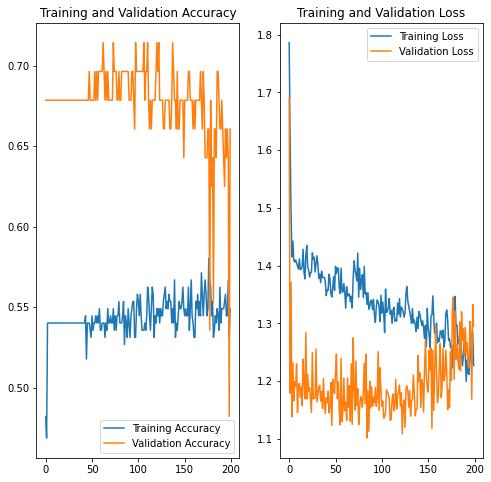

In [188]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [134]:
model.save('./modelo_entrenado/emociones_anime_model')

INFO:tensorflow:Assets written to: ./modelo_entrenado/emociones_anime_model/assets


INFO:tensorflow:Assets written to: ./modelo_entrenado/emociones_anime_model/assets


## Acciones tomadas

1. Para reducir el underfitting decidi incrementar las densidades de las capas convolutivas, inicie eliminando todas y agregando una para posteriormente ir incrementando su densidad hasta que no hubiera mejoras en el modelos, para posteriormente seguir agreando capas repitiendo el proceso hasta que no hubiera mejoria agregando capas.

2. El modelo seguia haciendo underfitting, pero a una mejor escala, por lo que decidi probar el modelo sin las capas de max pooling, lo cual mejoro un poco el underfitting, sin embargo no merecia la pena en comparacion al incremento de costo de calculo, por lo que las volvi a agregar.

3. Me percate que habia llegado al maximo de la arquitectura que habia planteado, y que el modelo seguia haciendo underfitting por lo que decidi modificar las densidades y cantidades de capas intermedias entre las convolutivas y la de clasificacion, obteniendo que lo mejor es una unica capa de menor densidad.

4. Una vez que ya tenia mi modelo sin underfitting, fui entrenando mi modelo con 130 epocas, las cuales eran el punto donde empezaba a hacer overfitting, por lo que fui agregando capas de dropouts para evitar el overfitting, y una vez que tenia un modelo adecuado, lo entrene hasta las 200 epocas.

## Observaciones

Si bien el modelo no mejoro mucho en la precision, si lo hizo considerablemente en el entendimiento de los datos, por lo que objetivamente podemos decir que este es un modelo mejor que el original.

# Modelo pre entrenado

## MobileNetV2

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Importamos el modelo pre entrenado

In [ ]:
IMG_SHAPE = (64,64) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

Generamos las capas necesarias para realizar nuestras predicciones

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Creamos un nuevo modelo a partir de juntar las nuevas capas con el modelo pre entrenado.

In [ ]:
# Recibe nuestras imagenes de 64 x 64
inputs = tf.keras.Input(shape=(64, 64, 3))
# Genera datos extras aplicandole transformaciones a los existentes
x = data_augmentation(inputs)

# Reduce el rango de los valores de las imagenes, sustituyendo la capa que haciamos con Rescaling
x = preprocess_input(x)

# Modelo pre entrenado, desativado para no entrenar
x = base_model(x, training=False)

# Capas para generar las predicciones
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

# Modelo nuevo
model = tf.keras.Model(inputs, outputs)

Compilamos y entrenamos nuestro nuevo modelo

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/30
7/7 [==============================] - 4s 109ms/step - loss: 0.2424 - accuracy: 0.2411 - val_loss: 0.4404 - val_accuracy: 0.2143
Epoch 2/30
7/7 [==============================] - 0s 32ms/step - loss: 0.1222 - accuracy: 0.2500 - val_loss: 0.4057 - val_accuracy: 0.1786
Epoch 3/30
7/7 [==============================] - 0s 31ms/step - loss: -0.1180 - accuracy: 0.1295 - val_loss: 0.3796 - val_accuracy: 0.1250
Epoch 4/30
7/7 [==============================] - 0s 32ms/step - loss: -0.7474 - accuracy: 0.2009 - val_loss: 0.3637 - val_accuracy: 0.1071
Epoch 5/30
7/7 [==============================] - 0s 31ms/step - loss: -0.2539 - accuracy: 0.1741 - val_loss: 0.3553 - val_accuracy: 0.0714
Epoch 6/30
7/7 [==============================] - 0s 33ms/step - loss: -0.6209 - accuracy: 0.1473 - val_loss: 0.3568 - val_accuracy: 0.0536
Epoch 7/30
7/7 [==============================] - 0s 32ms/step - loss: -0.5902 - accuracy: 0.1562 - val_loss: 0.3616 - val_accuracy: 0.0536
Epoch 8/30
7/7 [=====

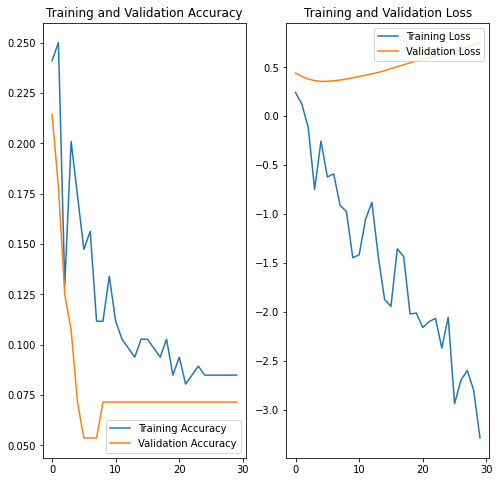

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusiones

Posemos observar a simple vista en el comportamiento del modelo que es incapaz de utilizar las capas previamente entrenada para satisfacer el problema.

# Predicciones

Predicciones realizadas con el mejor modelo obtenido.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.load_weights('././checkpoints/my_checkpoint')

In [ ]:
def predict(model, path):

    img = tf.keras.utils.load_img(
        path, target_size=(64, 64)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img_array[0].numpy().astype("uint8"))

    print(
        "El estado de animo es {} con un {:.2f} porciento de confianza."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [ ]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Alegria/111.png')

FileNotFoundError: [Errno 2] No such file or directory: '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Alegria/111.png'

1/1 [==============================] - 0s 13ms/step
El estado de animo es Alegria con un 54.40 porciento de confianza.


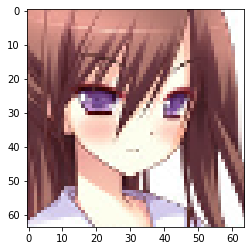

In [ ]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Enojo/122.png')

1/1 [==============================] - 0s 15ms/step
El estado de animo es Alegria con un 47.10 porciento de confianza.


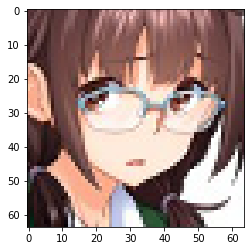

In [ ]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Miedo/21403.png')

1/1 [==============================] - 0s 13ms/step
El estado de animo es Alegria con un 38.83 porciento de confianza.


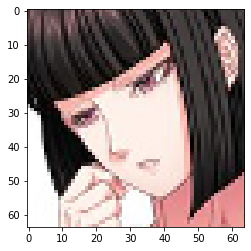

In [ ]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Tristeza/21391.png')

# Conclusiones

- Mediante la incrementacion tanto de capas convolutivas, como de sus densidades, logre reducir el underfittings, y con una capa de dropout eliminar el overfitting resultante de de los cambios. Si bien la mejora en la precision no es mucha, al analizar los loss de entrenamiento y validacion si podemos observar una mejora en el entendimiento de los datos por parte del modelo, por lo que podriamos esperar que al llevar a cabo un entrenamiento con mas epocas mejorara la precision del modelo.


- Usar un modelo pre entrenado no aporto nada, posiblemente porque fue entrenado para clasificar cuestiones muy diferentes a las presentes en el dataset, haciendo de tal manera que las capaz intermedias del nuevo modelo dadas por el modelo pre entrenado tengan un peor desempeño que realizando la prediccion de forma aleatoria.